<!-- toc -->

- [About this tutorial](#about)
- [Installation](#installation)
- [Compilation](#compilation)
- [Running](#running)
- [Code Validation](#validation)
- [Run in parallel with MPI](#mpi)
- [Next tutorial: your first setup](#next)

<!-- tocstop -->
<a id="about"></a>
# About this tutorial
This tutorial is provided as a github repository and is mirrored on Jureca for easier access. It is part of the [Toward Exascale-Ready Astrophysics workshop](https://indico3-jsc.fz-juelich.de/event/169/) and has been prepared by Geoffroy Lesur (geoffroy.lesur@univ-grenoble-alpes.fr)

In this tutorial, you will learn how to use idefix on various architectures. Here, we will do everything through a Jupyter notebook opened on Jureca on the `dc-gpu` partition.



# Deployment on Jureca

Log in to https://jupyter-jsc.fz-juelich.de/

Open a lab environment with

- Lab Config:
    - System: JURECA
    - Project: training2437
    - Partition: dc-gpu
    - Reservation: tera_day2
- Resources (opens once dc-gpu is selected)
    - Nodes: 1
    - GPUs: 4
    - Runtime: 90
Kernels and extensions: keep defaults


First open a new console on your Jupyter notebook. We then clone the idefix Github repository. Since we don't have direct access to the internet, we use a small script to copy the sources and the tutorial from a shared directory:

```shell
source /p/project1/training2437/tera_day2/idefix/deploy.sh
```

This will put everything into `/p/project1/training2437/tera_day2/$USER/idefix`

The deploy script already set up the environement (module and environement variable). If you loose connection and need a new console, you can reload the environement:

```shell
source /p/project1/training2437/tera_day2/idefix/env.sh
```

We also need to load Idefix environement in this Jupyter notebook:

In [2]:
# import Idefix python tools (part of the Idefix git repo, so we add this to python path) 
%matplotlib widget
import os
import sys
# These path are specific to this Jureca tutorial
user=os.getenv("USER")
sys.path.append("/p/project1/training2437/tera_day2/"+user+"/idefix/idefix.src/")
from pytools.vtk_io import readVTK
import matplotlib.pyplot as plt
import numpy as np

and you're good to go!

## Optionnal: Deploy on your machine

<details> 
<summary>Click here to deploy Idefix on your laptop.</summary>
<br>
Optionnally, you can play around with this tutorial on your laptop/machine. In this case you can clone this tutorial and idefix source code on your machine, so that you can directly use these source files and test what you are doing. In the directory of your choice (this requires an internet access):

```shell
git clone --recurse-submodules https://github.com/idefix-code/idefix.git idefix.src
export IDEFIX_DIR=$PWD/idefix.src
git clone https://github.com/idefix-code/tutorial.git
cd tutorial
git checkout Jureca
```
The last line allows you to reach the dedicated tutorial for Jureca.

For conveniance, we set the `IDEFIX_DIR` environment variable to the absolute path of the root directory of idefix (as above). 

If you intend to use the python script provided in this tutorial, best is to deploy a python environement with everything already set up. 
We therefore create a python environement in the directory `$IDEFIX_DIR/test` with the right modules (this may require an internet access)

```shell
cd $IDEFIX_DIR/test
python3 -m venv ./env
source env/bin/activate
pip install -r python_requirements.txt
```

</details>


# Basics: configuration, compilations, run on CPUs
<a id="compilation"></a>
## Compile an example

Let's play with a simple Sod shock tube test in hydro:

```shell
cd $IDEFIX_DIR/test/HD/sod
```

Configure the code launching cmake (version >= 3.16) in the example directory:

```shell
cmake $IDEFIX_DIR
```

By default, this will configure the code to run on the CPU only. We will see later how to configure the code for GPU.

Several options can be enabled from the command line (a complete list is available with `cmake $IDEFIX_DIR -LH`). For instance: `-DIdefix_RECONSTRUCTION=Parabolic` (enable PPM reconstruction), `-DIdefix_MPI=ON` (enable mpi), `-DKokkos_ENABLE_OPENMP=ON` (enable openmp parallelisation), etc... For more complex target architectures, it is recommended to use cmake GUI launching `ccmake $IDEFIX_DIR` in place of `cmake` and then switching on the required options.

One can then compile the code:

```shell
make -j8
```

<a id="running"></a>
## Run an example

launch the executable

```shell
srun -n 1 ./idefix
```

You should see idefix finishing successfully.
<a id="validation"></a>
## Code Validation

Most of tests provided in the `test/` directory can be validated against analytical solution (standard test)
and/or pre-computed solutions (non-regression tests). Note that the validation relies on large reference
files that are stored in the separate `idefix-code/reference` repository that is automatically cloned as a submodule.

In order to check that our test produced the right result, we are going to use the script `testme.py`. 

```sell
./testme.py -check
```

> :warning: **If you are using a Mac with an ARM cpu (M1/M2)**: The non-regression test might not succeed (but standard tests should always pass): this is linked to slight differences in the way roundoff errors are treated on these architectures.
<a id="mpi"></a>
## Run in parallel with MPI

Note: This section requires an MPI library on your machine.

In order to use Idefix with parallel domain decomposition (either on CPUs or on GPUs), you should first configure the code with MPI enabled using the `Idefix_MPI=ON` option. Let's try that for the Orszag-Tang vortex test

```shell
cd $IDEFIX_DIR/test/MHD/OrszagTang
cmake $IDEFIX_DIR -DIdefix_MPI=ON
make -j 8
```

if your build is successful, you can now try to launch idefix with automatic domain decomposition. On a Jureca node (using Slurm):

```shell
srun -n 4 ./idefix
```

<details>
<summary>(optional) On your laptop:</summary>

```shell
mpirun -np 4 ./idefix
```
</details>



# Configuration, compilation, run on GPUs
## First tests

For this first test, we are going to run a simple Orszag-Tang test problem on a single GPU. First cd to the right directory

```shell
cd $IDEFIX_DIR/test/MHD/OrszagTang
```

<a id="configuration"></a>
### Configuring/compiling the code for GPUs using CMAKE

The code configuration can be a bit tricky. When you're not sure about the options, best is to use `ccmake`, a graphical version of `cmake` to switch on and off the options you need. Here, we know we're going to use 
an Nvidia GPU so we will be using CUDA. Moreover, we will configure the code on a GPU node, so we can let cmake auto-detect the right Nvidia architecture for us:

```shell
cmake $IDEFIX_DIR -DKokkos_ENABLE_CUDA=ON
make -j 8
```

While the code configure, you will see that it indeed auto-detect the `AMPERE_80` architecture. If this auto-configuration was to fail (i.e. configuring on a login node), we could add `-DKokkos_ARCH_AMPERE80=ON` to specify the right architecture.

Note that it is always possible to run Idefix compiled for an older architecture (Pascal) on a new one (Ampere), you will only get a warning: `running kernels compiled for compute capability 6.1 on device with compute capability 8.6 , this will likely reduce potential performance.`. The opposite however doesn't work, if you try you will get an error message `Kokkos::Cuda::initialize ERROR: likely mismatch of architecture`

Note that compilation for GPUs can take a looooooong time, so it is always recommended to parallelise the compilation with the `-j` option of `make`.

<a id="running"></a>
### Running the code on GPUs

You then simply launch the executable using srun:

```shell
srun -n 1 ./idefix
```

You should see Idefix running and finishing rapidly its computation (you can compare the performances in cell/s to the ones you obtain on your laptop for instance for the same test). 

<a id="mpi"></a>
### Multi-GPUs runs

Idefix can run on multiple GPUs (it's been tested on +4000 GPUs simultaneously). This requires an MPI installation compatible with Cuda (e.g. GPU-aware OpenMPI). If you have loaded the environement in [Getting Started](README.md), you should be able to compile a GPU version of Idefix with parallelisation support.

You should first configure the code with CMake adding `-DIdefix_MPI=ON` to the command line and compile. 

```shell
cmake $IDEFIX_DIR -DKokkos_ENABLE_CUDA=ON -DIdefix_MPI=ON
make -j 8
```

If the compilation succeeds, then you can run a multi-GPU simulation with 4 gpus:

```shell
srun -n 4 ./idefix
```

Note that with the module configuration we used above, the code automatically uses NVLink when available and Cuda-Aware MPI (i.e. direct GPU-GPU communications).

# A simple setup

For this first simple setup, we move in the SimpleSetup/problem1 directory of the tutorial. i.e

```shell
cd /p/project1/training2437/tera_day2/$USER/idefix/tutorial/SimpleSetup/problem1/
```

## What is an idefix setup?

Idefix consist of its main trunk (that you downloaded from github, located in `$IDEFIX_DIR/src`) and a user-specified setup, made of at least 3 files (see below). An idefix setup can be located anywhere on your disk. When we will configure and build idefix, we will do it *from the setup directory*. Hence, the main idefix trunk will be built against your setup, and an executable file will be created in your setup directory. Therefore, all of your coding, configuration, compilation and runs should happen in the setup directories proposed in this tutorial.

In principle, there is *no need* to modify your idefix main trunk, and in particular in this tutorial, it will be left untouched. This separation between the user setup, and the idefix sources limits the risk that you break something fundamental in idefix. Moreover, it simplifies updates, as you just have to `git pull` new versions of idefix in `$IDEFIX_DIR`.

For those familiar with the Pluto code, they should feel at home. Indeed, Idefix has been designed to simplify portability from Pluto, so several design features are recovered in idefix. Still, keep in mind that Pluto and Idefix are not the same code, even though they share several user-space properties.

## The 3 main files of an idefix setup

Every idefix setup is divided into 3 files: definitions.hpp, idefix.ini and setup.cpp.  Let's see what contains each file:

- definitions.hpp contains preprocessor directives describing the number of dimensions, the equation of state and the geometry of the problem. Any modification of this file requires a recompilation. [More about definitions.hpp](https://idefix.readthedocs.io/latest/reference/definitions.hpp.html) 
- idefix.ini contains parameters read at *runtime* by idefix. It contains directives organized by blocks [...]. Notably, the domain size, resolution (in the [Grid] block), the Hydro solver, the time integrator, the boundary conditions, etc. There is no need to recompile if you change this file. [More about idefix.ini](https://idefix.readthedocs.io/latest/reference/idefix.ini.html).
- setup.cpp contains the C++ code specific to your setup. At minimum it should contain a Setup constructor and a method to initialise the flow. [More about setup.cpp](https://idefix.readthedocs.io/latest/reference/setup.cpp.html)

## About this problem

This problems proposes to set up a simple Kelvin Helmholtz instability flow that consist of two layers of fluid moving in opposite directions.

![alt text](SimpleSetup/img/flowScheme.png)

The interface is designed with a weak initial perturbation that will grow because of the Kelvin-Hemholtz instability. We will assume the flow is periodic in $x$ and we will use outflow (i.e. non-reflective) boundary conditions in the $y$ and $z$ direction.

In this problem, we have left some holes that you will have to fill with the documentation. These are identified by `## TBF ##` or `//TBF//` in the source code.

## Your work
### Define the boundary conditions

In this setup, we want periodic boundary conditions in the $x$ direction, and outflow boundary conditions in the $y$ and $z$ directions. Edit `idefix.ini` to define your boundary conditions. The [documentation](https://idefix.readthedocs.io/latest/reference/idefix.ini.html#boundary-section) might be handy! 

### Read the flow velocity from idefix.ini

In this setup, we want to vary the flow velocity without recompiling the code. Idefix allows you to define as many blocks and parameters as you wish in your input file (.ini). Here, we have defined a block `[Setup]` with our parameter `flowVelocity`. We should now fetch this parameter in our `setup.cpp` code.

This is typically done in the setup constructor (`Setup::Setup` in setup.cpp), using the `Get` method that belongs to the `Input` class. Have a look at the [example](https://idefix.readthedocs.io/latest/reference/setup.cpp.html#example) provided in the user guide, and at the [documentation of the `Input::Get` method](https://idefix.readthedocs.io/latest/programmingguide.html#the-input-class) in the programming guide.

### Define your initial conditions

Our last task is to define our initial conditions. This is done in the `Setup::InitFlow` method. We have already
prepared a loop on the domain for you, so you just have to fill the holes, knowing that $v_x=$ flowVelocity when $y\gt y_{\rm interface}$ and $v_x=-$ flowVelocity when $y\lt y_{\rm interface}$. Here again, the [documentation](https://idefix.readthedocs.io/latest/reference/setup.cpp.html#setup-initflow-method) might help. 

### Configure the code, build and run it

Follow the instruction in the [Getting Started](../GettingStarted/README.md#compile-an-example) section. Note that you can run your setup on a CPU or an GPU, choosing the right configuration with `Cmake`.

### Check the outputs

To visualize the flow, you may use Paraview or visit to open the files generated by Idefix. On Jureca, you can open the notebook `read_problem.ipynb` in `SimpleSetup/problem1` and execute it to visualize the result directly.



In [8]:
# Load the last VTK file produced by Idefix
V=readVTK("SimpleSetup/problem1/data.0005.vtk")

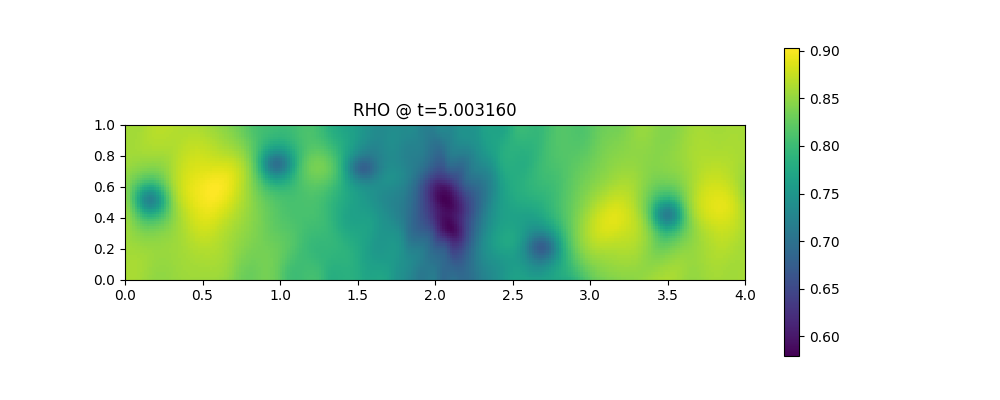

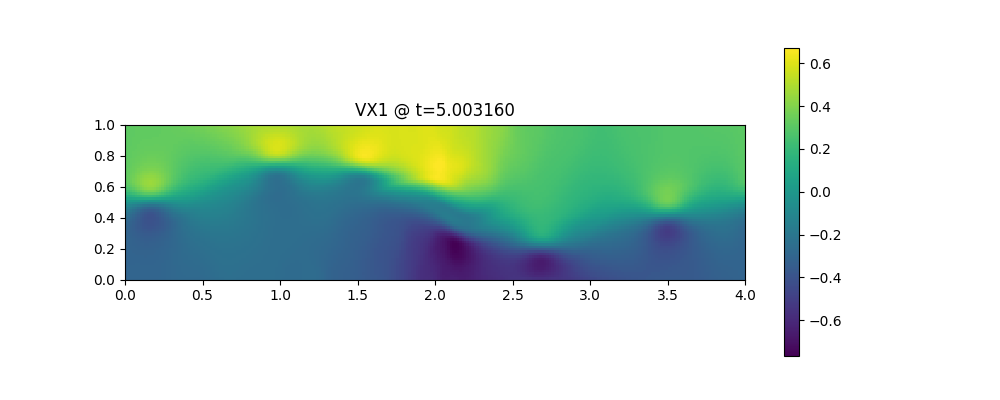

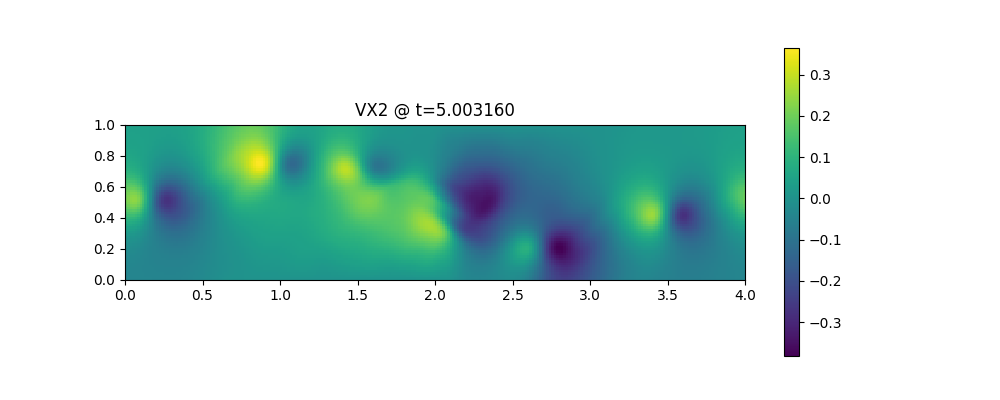

In [9]:
# Display all fields
for field in V.data.keys():
  plt.figure(figsize=(10,4))
  plt.pcolormesh(V.x,V.y,V.data[field][:,:,0].T)
  plt.title(field+ " @ t=%f"%V.t)
  plt.colorbar()
  plt.gca().set_aspect('equal')

In [11]:
# compute vorticity
wz = np.gradient(V.data['VX2'],V.x,axis=0)-np.gradient(V.data['VX1'],V.y,axis=1)

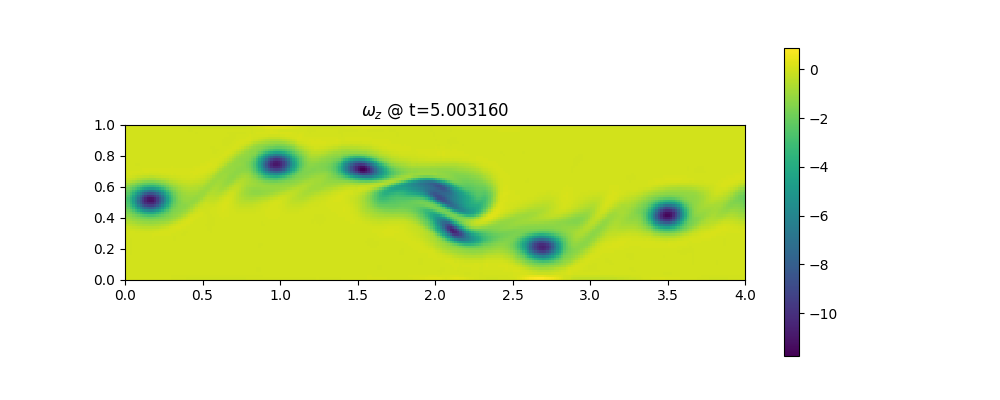

In [12]:
plt.figure(figsize=(10,4))
plt.pcolormesh(V.x,V.y,wz[:,:,0].T)
plt.title(r"$\omega_z$ @ t=%f"%V.t)
plt.colorbar()
plt.gca().set_aspect('equal')

### Change resolution

Try to compile the code for a single GPU (without MPI). The initial resolution is $256\times 64$. Edit `idefix.ini` and try to increase the resolution to $512\times 128$

### Play with your setup

Now, you can increase (without recompiling!) the flow speed beyond the sound speed (here =1.0 in the setup)
to see the effect on compressibility. You can also try to use [parallelism with MPI](#mpi) to speed up the computation
